# Usecase of SAM for Medical Imaging

The Medical SAM (Segment Anything Model) repository is a fork of the original SAM repository with modifications to support object segmentation in medical imaging using DICOM files. The SAM model is a state-of-the-art object segmentation model that predicts object masks given prompts that indicate the desired object. This implementation uses SAM to efficiently produce high-quality masks from prompts for medical imaging tasks using DICOM files. It allows the user to provide box prompt via the SamPredictor class to predict masks for a given medical DICOM file.

## Clone the Repo
The code for the SAM setup can be cloned directly from my repo [here](https://github.com/amine0110/SAM-Medical-Imaging).

In [2]:
!git clone https://github.com/amine0110/SAM-Medical-Imaging
%cd SAM-Medical-Imaging

Cloning into 'SAM-Medical-Imaging'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 50 (delta 13), reused 34 (delta 5), pack-reused 0
Receiving objects: 100% (50/50), 1.01 MiB | 4.30 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/Users/tnmthai/Documents/GitHub/gis-medium/examples/notebooks/SAM-Medical-Imaging


In [3]:
import sys
!{sys.executable} -m pip install opencv-python matplotlib    
!pip install pydicom  
!wget -P model https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.2 MB/s eta 0:00:00a 0:00:01m
--2023-05-12 21:13:01--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 54.192.177.11, 54.192.177.93, 54.192.177.117, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|54.192.177.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘model/sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  35.6MB/s    in 68s     

2023-05-12 21:14:09 (36.1 MB/s) - ‘model/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [12]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import cv2
import pydicom
# from google.colab.patches import cv2_imshow

In [13]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([255/255, 200/255, 0/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

### Import a classic image

In [14]:
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

### Import a medical imaging image (dcm image)

In [17]:
def prepare_dicoms(dcm_file, show=False):
    dicom_file_data = pydicom.dcmread(dcm_file).pixel_array

    HOUNSFIELD_MAX = np.max(dicom_file_data)
    HOUNSFIELD_MIN = np.min(dicom_file_data)

    HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

    dicom_file_data[dicom_file_data < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    dicom_file_data[dicom_file_data > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    normalized_image = (dicom_file_data - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE
    uint8_image = np.uint8(normalized_image*255)

    opencv_image = cv2.cvtColor(uint8_image, cv2.COLOR_GRAY2BGR)

    if show:
        cv2.imshow(opencv_image)

    return opencv_image

In [18]:
img = prepare_dicoms('images/slice.dcm', show=True)

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)


In [44]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "model/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [64]:
predictor.set_image(img)

In [24]:
input_box = np.array([100, 100, 400, 400])

In [73]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

### Show Image + Output Mask + Bounding Box

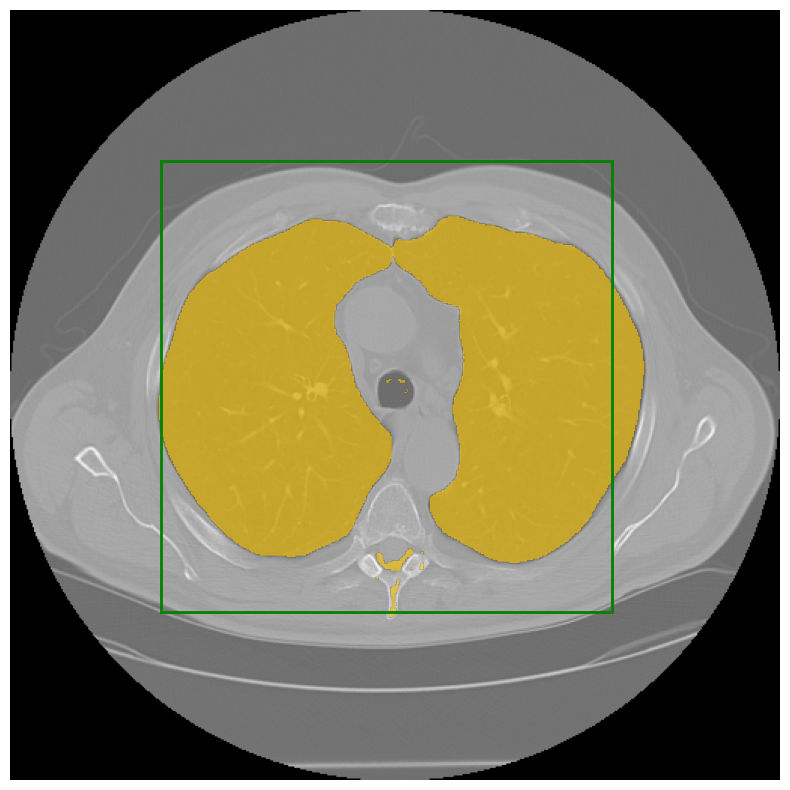

In [74]:
plt.figure(figsize=(10, 10))
plt.imshow(img)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()